In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [184]:
#data preprocessing
all_data = np.loadtxt('spambase.data', delimiter=',')
X_all = all_data[:, :-1]
y_all = all_data[:, -1]

#dimension of input
X_dim = X_all.shape[1]

Log Loss function evaluated at each datapoint:

$L_i = -y_i\ log(\sigma(\beta \cdot x_i)) - (1-y_i)\ log (1 - \sigma(\beta \cdot x_i))$

$\frac{\partial L_i}{\partial \beta} = (\sigma(\beta \cdot x_i) - y_i )\ x_i $

In [5]:
#logistic loss and its gradient, evaluated at each datapoint
def sigmoid(beta, x_i):
    #addressing log(0) error
    if 1/(1+ np.exp(-1*np.dot(beta, x_i))) < 1e-12:
        return 1e-12
    
    if 1/(1+ np.exp(-1*np.dot(beta, x_i))) > 1 - 1e-12:
        return 1 - (1e-12)
    
    return 1/(1+ np.exp(-1*np.dot(beta, x_i)))

def logistic_loss(x_i, y_i, beta):
    return (-1)* y_i * np.log(sigmoid(beta, x_i)) - (1 - y_i)*np.log(1 - sigmoid(beta,x_i))
    
def total_loss(X, y, beta):
    loss = 0
    for i in range(len(y)):
        loss += logistic_loss(X[i, :], y[i], beta)
    return loss/(len(y))
        
def logistic_gradient(x_i, y_i, beta):
    return (sigmoid(beta, x_i) - y_i )*x_i.T

$\hat y = sgn (\hat{\beta_0} +  \frac{X - \bar X}{s} \hat {\beta_{-0}}) \newline
= sgn ((\hat \beta_0 - \frac{\bar X}{s} \hat {\beta_{-0}}) + X \frac{\hat{\beta_{-0}}}{s}) \newline
= sgn ( \tilde {\beta_0} + X \tilde {\beta_{-0}}) 
$, where $\tilde {\beta_0}= \hat \beta_0 - \frac{\bar X}{s} \hat{\beta_{-0}}$ and $\tilde {\beta_{-0}} = \frac{\hat{\beta_{-0}}}{s} $

In [155]:
#gradient descent
def gradient_descent(X, y, alpha, beta, epochs, normalization):
    
    #centering and standardizing  

    if normalization == 1: 
        mean = np.mean(X, axis=0)
        std = np.std(X, axis = 0)
        X = X - mean * np.ones_like(X)
        X = X/std
    else: 
        mean = np.zeros(X.shape[1])
        std = np.ones(X.shape[1])
        
    #add column of intercepts
    X = np.column_stack((np.ones(len(X)), X))

    grad_vec = np.zeros(X.shape[1])
    losses = []
    
    for t in range(epochs):
        
        #summing the gradients evaluated at each datapoint
        for i in range(len(y)):
            grad_vec = grad_vec + logistic_gradient(X[i, :], y[i], beta)
        
        #divide by #datapoints
        grad_vec = grad_vec / len(y)
        
        #updating by gradient descent
        beta = beta - alpha * grad_vec
        
        #plot losses after each iteration
        loss = total_loss(X,y,beta)
        losses.append(loss)
        
        if t > 1:
            if np.abs(loss - losses[t-1]) < 1e-10:
                print('stopping criteria met')
                break
        
    losses = np.asarray(losses)
    plt.plot(losses)
    plt.show()
    print(losses[-1])

    #transform weight vectors 
    beta_t = np.zeros(X.shape[1])
    beta_t[0] =  beta[0] - np.dot(mean/std, beta[1:])
    beta_t[1:] = (1/std)*beta[1:]
    return beta_t

In [154]:
#stochastic gradient descent

def stochastic_gradient_descent(X, y, alpha, beta, batch_size, epochs):
    
    #normalization of input
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = X - mean * np.ones_like(X)
    X = X/std

    #add column of intercepts
    X = np.column_stack((np.ones(len(X)), X))
    
    grad_vec = np.ones(X.shape[1])
    
    losses = []
    index_list = np.arange(len(y))
        
    #randomly choose datapoints 
    batch = np.random.choice(index_list, batch_size)
    
    for t in range(epochs):
        for i in batch:
            idx = index_list[i]
            grad_vec += logistic_gradient(X[idx, :], y[idx], beta)
            
        grad_vec = grad_vec / batch_size
            
        beta = beta - alpha * grad_vec
        
        loss = total_loss(X,y,beta)
        losses.append(loss)
        
        if t > 1:
            if np.abs(loss - losses[t-1]) < 1e-9:
                print('stopping criteria met')
                break
        
    losses = np.asarray(losses)
    plt.plot(losses)
    plt.show()
    print(losses[-1])

    
    #transform weight vectors 
    beta_t = np.zeros(X.shape[1])
    beta_t[0] =  beta[0] - np.dot(mean/std, beta[1:])
    beta_t[1:] = (1/std)*beta[1:]
    
    return beta_t
    

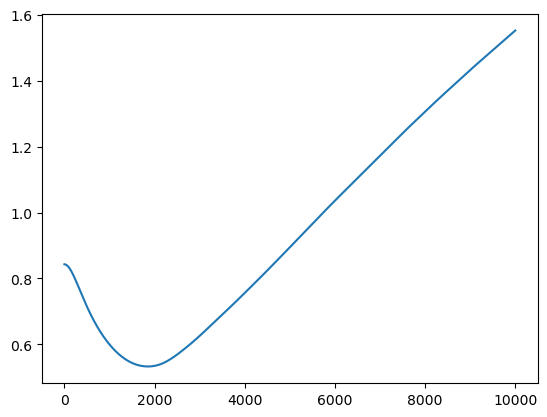

1.5524461224125996
0.1791530944625407


In [226]:
#cross-validation

#initialize the weight vector
beta_0 = 0.2*np.ones(X_dim+1)

#train-test split        
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

#0.105; beta_gd = gradient_descent(X_train, y_train, 0.02, beta_0, 1000)
#0.105; beta_gd = gradient_descent(X_train, y_train, 0.04, beta_0, 500)
#0.088: beta_gd = gradient_descent(X_train, y_train, 0.08, beta_0, 600)
#0.088: beta_gd = gradient_descent(X_train, y_train, 0.16, beta_0, 300)
#0.087: beta_gd = gradient_descent(X_train, y_train, 0.32, beta_0, 200)
#0.088: beta_gd = gradient_descent(X_train, y_train, 0.32, beta_0, 150)
#0.087: beta_gd = gradient_descent(X_train, y_train, 0.64, beta_0, 100) #optimal so far.

#0.35: beta_sgd_1 = stochastic_gradient_descent(X_train, y_train, 0.00015, beta_0, 1, 2000)
#0.22: beta_sgd_1 = stochastic_gradient_descent(X_train, y_train, 0.000005, beta_0, 1, 10000)

#sometimes diverges: beta_sgd_5 = stochastic_gradient_descent(X_train, y_train, 0.005, beta_0, 5, 2000)
#～0.25: beta_sgd_5 = stochastic_gradient_descent(X_train, y_train, 0.0025, beta_0, 5, 3000)

#0.25: beta_sgd_10 = stochastic_gradient_descent(X_train, y_train, 0.003, beta_0, 10, 3000)
#0.25: beta_sgd_10 = stochastic_gradient_descent(X_train, y_train, 0.003, beta_0, 10, 3000)

print(get_error_rate(X_test, y_test, beta_sgd_1))

#more iterations sometimes cause a resurgence in loss so we should reduce #iterations? 
#for smaller batchsize, increase the stopping criteria?

In [151]:
def get_error_rate(X_test, y_test, beta_t):
    
    y_hat = beta_t[0] + X_test@(beta_t[1:])
    y_hat[y_hat >= 0] = 1
    y_hat[y_hat < 0] = 0
    errors = y_hat - y_test
    error_rate = np.count_nonzero(errors) / len(y_test)
    return error_rate

In [216]:
#choose one feature with more non-zero entries
X_zero = np.count_nonzero(X_all, axis=0)
print(X_zero)

[1053  898 1888   47 1748  999  807  824  773 1302  709 2325  852  357
  336 1241  963 1038 3227  424 2423  117  679  735 1090  811  780  463
  372  469  293  205  405  215  485  599  829   83  384  453  148  341
  375  327 1311  517   63  203  790 2715  529 2258 1400  750 4601 4601
 4601]


stopping criteria met


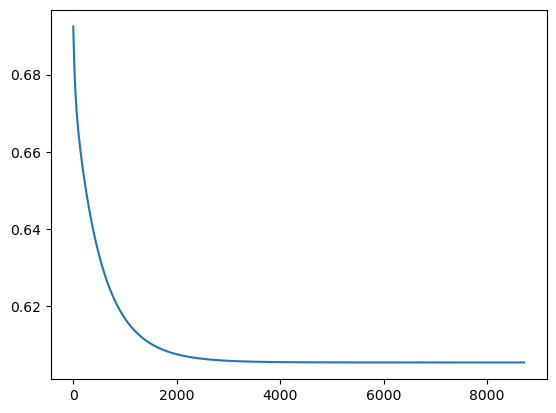

0.6053690048571174
stopping criteria met


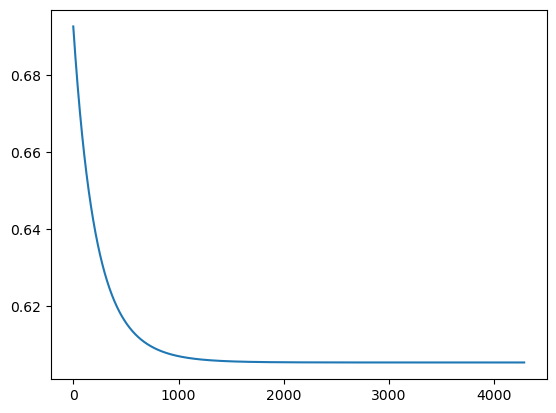

0.6053689700668266


In [212]:
#1 fixed feature, 100 random samples
b_0 = np.array([0.0001, 0.0001])
feature = 18
sample = np.random.choice(np.arange(0, len(y_all)),  100)

X_1 = X_all[sample,:]
X_1 = X_1[:, feature].reshape((100,1))

y_1 = y_all[sample]

#compute optimal weights for unstandardized and standardized data
beta_without_n = gradient_descent(X_1, y_1, 0.01, b_0, 50000, 0)
beta_with_n = gradient_descent(X_1, y_1, 0.01, b_0*np.std(X_1), 50000, 1)

In [225]:
#compare (adjusted) weight vectors
print('2 optimal weight vectors:', beta_without_n, beta_with_n)

#print predictions for both approaches and compare
y_hat = beta_without_n[0] + X_1@(beta_without_n[1:])
y_hat_n = beta_with_n[0] + X_1@(beta_with_n[1:])
print('predictions for 100 training samples: \n', y_hat, '\n\n', y_hat_n)

2 optimal weight vectors: [-1.15916143  0.56899407] [-1.15978321  0.56907389]
predictions for 100 training samples: 
 [-0.37394961 -1.15916143  0.88921723 -0.82914487 -1.15916143 -0.41946914
 -0.45929872 -0.0780727   1.11681485 -0.45929872  0.32591309  2.85224677
 -0.32274015 -1.15916143 -1.15916143 -0.92018392 -0.37394961 -0.82345493
 -1.15916143 -0.99984309 -1.15916143 -0.2886005   0.84938764  0.43971191
 -0.16342181 -0.43653896 -0.27722062  1.03146574  1.28182313 -1.15916143
  0.17797464  0.03003618 -0.03255317 -1.15916143 -0.49912831  0.08124564
  1.0257758  -1.15916143  0.8436977  -1.15916143 -0.11790228 -0.00410347
  1.09405509 -1.15916143 -0.00410347 -0.03255317  1.01439592  0.88921723
  0.61610007 -1.15916143 -0.57878748 -1.15916143 -1.15916143 -0.28291056
  0.86076752  0.66730954 -0.89173422  1.36717224 -1.15916143  0.04141606
  2.35153199 -0.40808926 -0.00979341  1.03146574 -0.08945258 -1.15916143
 -0.27153068 -0.70965611 -1.09088214  0.57627049 -1.15916143 -0.91449398
 -1.15

The results are fairly similar. 